In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import timm
import numpy as np
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torchvision.models import ResNet50_Weights
from PIL import Image
import pandas as pd
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from matplotlib import pyplot as plt

In [5]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(123)

In [6]:
IMAGE_HEIGHT = 299
IMAGE_WIDTH = 299
BATCH_SIZE = 16

In [7]:
class EarlyStopping:
    def __init__(self, patience=7, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [8]:
#================================Test data Evaluation===============================
def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = test_loss / len(test_loader)

    accuracy = correct / total * 100.0

    return avg_loss, accuracy

In [9]:
#========================Training data========================
def train_model(model, train_loader, num_epochs, test_loader):
    train_accuracy = []
    train_loss = []
    test_accuracy = []
    test_loss = []
    early_stopping = EarlyStopping(patience=5, delta=0.01)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        train_loss.append(epoch_loss)
        train_accuracy.append(epoch_acc)

        model.eval()
        with torch.no_grad():
            ts_loss, ts_acc = evaluate_model(model, test_loader)
            early_stopping(ts_loss, model)
            if early_stopping.early_stop:
                print("Early stopping")
                break

        test_loss.append(ts_loss)
        test_accuracy.append(ts_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.2f}% | Test Loss: {ts_loss:.4f}, Test Accuracy: {ts_acc:.2f}%')

    return train_loss, train_accuracy, test_loss, test_accuracy

transform = transforms.Compose([
    transforms.Resize((IMAGE_WIDTH, IMAGE_HEIGHT)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [10]:
from torchvision.datasets import ImageFolder
import os
class CustomImageFolder(ImageFolder):
    def find_classes(self, directory):
        classes = [d.name for d in os.scandir(directory) if d.is_dir() and d.name != '.ipynb_checkpoints']
        classes.sort()
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

In [11]:
#========================Loading training dataset===========================
dataset = CustomImageFolder(root='data/training', transform=transform)
#================================Loading test dataset================================
test_dataset = CustomImageFolder(root='data//test', transform=transform)

In [12]:
#==========================Creating batches based on the training dataset=====================
class_indices = [0, 1, 2]
train_dataset = torch.utils.data.Subset(dataset, [i for i in range(len(dataset)) if dataset.targets[i] in class_indices])
dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [13]:
#==========================Creating batches based on the test dataset=====================
test_dataset = torch.utils.data.Subset(test_dataset, [i for i in range(len(test_dataset)) if test_dataset.targets[i] in class_indices])
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Resnet50 Model

In [ ]:
model = models.resnet50(pretrained = True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

/scratch/abhishek.f/chatbot-cuda12_1/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/scratch/abhishek.f/chatbot-cuda12_1/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
#=================Training Resent50 model==================
train_loss, train_accuracy, test_loss, test_accuracy =  train_model(model, dataloader, 10, test_loader)

Epoch [1/10], Train Loss: 2.8179, Train Accuracy: 60.00% | Test Loss: 0.8490, Test Accuracy: 81.82%
Epoch [2/10], Train Loss: 0.4688, Train Accuracy: 91.46% | Test Loss: 0.8576, Test Accuracy: 86.87%
Epoch [3/10], Train Loss: 0.1446, Train Accuracy: 96.46% | Test Loss: 0.4496, Test Accuracy: 88.89%
Epoch [4/10], Train Loss: 0.0452, Train Accuracy: 98.75% | Test Loss: 0.5240, Test Accuracy: 87.88%
Epoch [5/10], Train Loss: 0.0359, Train Accuracy: 98.75% | Test Loss: 0.6078, Test Accuracy: 87.88%
Epoch [6/10], Train Loss: 0.0190, Train Accuracy: 99.58% | Test Loss: 0.3990, Test Accuracy: 87.88%
Epoch [7/10], Train Loss: 0.0543, Train Accuracy: 98.12% | Test Loss: 0.3244, Test Accuracy: 90.91%
Epoch [8/10], Train Loss: 0.0280, Train Accuracy: 98.96% | Test Loss: 0.3113, Test Accuracy: 90.91%
Epoch [9/10], Train Loss: 0.0169, Train Accuracy: 99.38% | Test Loss: 0.4457, Test Accuracy: 86.87%
Epoch [10/10], Train Loss: 0.0255, Train Accuracy: 99.79% | Test Loss: 0.4050, Test Accuracy: 87.88%

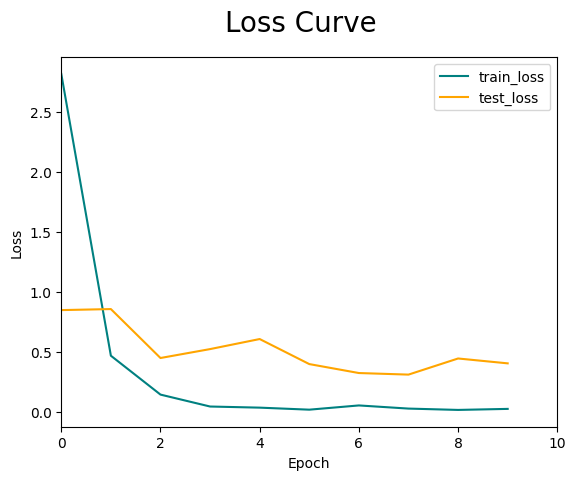

In [ ]:
#==========================Loss Function===========================
fig = plt.figure()
plt.plot(train_loss, color = 'teal', label = 'train_loss')
plt.plot(test_loss, color = 'orange', label = 'test_loss')
fig.suptitle('Loss Curve', fontsize = 20)
plt.legend(loc = 'upper right')
plt.xlim(0,10)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

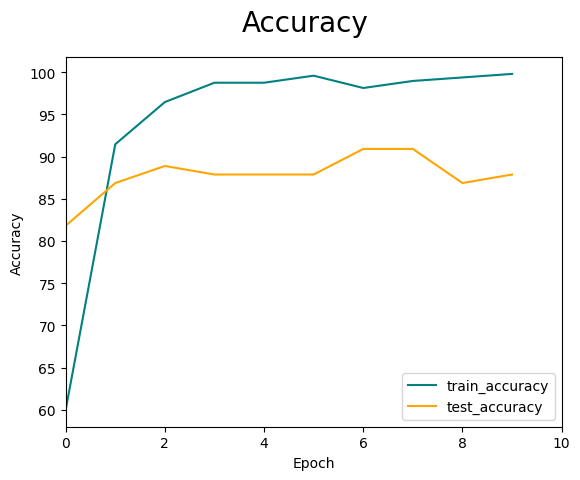

In [ ]:
#==========================Accuracy===========================
fig = plt.figure()
plt.plot(train_accuracy, color = 'teal', label = 'train_accuracy')
plt.plot(test_accuracy, color = 'orange', label = 'test_accuracy')
fig.suptitle('Accuracy', fontsize = 20)
plt.legend(loc = 'lower right')
plt.xlim(0,10)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [20]:
#===========================Evaluate the model based on the validation dataset=====================
label_map = {'ChickenPox': 0, 'Measles': 1, 'MonkeyPox': 2}

def getType(id):
    return list(label_map.keys())[list(label_map.values()).index(id)]


def predict_images_class(model, val_data, image_width, image_height):
    val_df = pd.DataFrame(columns=['Image No.', 'Predicted Image Class'])
    cnn_img = [os.path.join(val_data, file) for file in os.listdir(val_data)[:]]

    for i, img_path in enumerate(cnn_img):
        image = Image.open(img_path).convert('RGB')
        image = transform(image)
        img = image.unsqueeze(0)
        with torch.no_grad():
            prediction = model(img)
        predicted_class_index = torch.argmax(prediction).item()
        predicted_class = getType(predicted_class_index)
        val_df.loc[len(val_df.index)] = [(i+1), predicted_class]

    return val_df

In [23]:
val_chicken_pox = os.path.join (r"data/validation/ChickenPox")
val_measles = os.path.join (r"data/validation/Measles")
val_monkey_pox = os.path.join (r"data/validation/MonkeyPox")

## Prediction on New Images

In [ ]:
chickenpox_val_df_cnn = predict_images_class(model, val_chicken_pox, IMAGE_WIDTH, IMAGE_HEIGHT)
display(chickenpox_val_df_cnn)

,Image No.,Predicted Image Class
0,1,ChickenPox
1,2,ChickenPox
2,3,ChickenPox
3,4,ChickenPox
4,5,ChickenPox
5,6,ChickenPox
6,7,ChickenPox
7,8,Measles


In [ ]:
measles_val_df_cnn = predict_images_class(model, val_measles, IMAGE_WIDTH, IMAGE_HEIGHT)
display(measles_val_df_cnn)

,Image No.,Predicted Image Class
0,1,Measles
1,2,Measles
2,3,Measles
3,4,ChickenPox
4,5,ChickenPox
5,6,Measles
6,7,Measles
7,8,Measles


In [ ]:
monkey_pox_df_cnn = predict_images_class(model, val_monkey_pox, IMAGE_WIDTH, IMAGE_HEIGHT)
display(monkey_pox_df_cnn)

,Image No.,Predicted Image Class
0,1,MonkeyPox
1,2,MonkeyPox
2,3,MonkeyPox
3,4,Measles
4,5,Measles
5,6,Measles
6,7,MonkeyPox
7,8,MonkeyPox


## NesNet-A-Large Model




In [27]:
model_se = timm.create_model('nasnetalarge', pretrained=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_se.parameters(), lr=0.0001)

In [16]:
#=================Training SE-ResNeXt-101 model==================
train_loss_se, train_accuracy_se, test_loss_se, test_accuracy_se =  train_model(model_se, dataloader, 10, test_loader)

Epoch [1/10], Train Loss: 3.4462, Train Accuracy: 43.54% | Test Loss: 0.8113, Test Accuracy: 79.80%
Epoch [2/10], Train Loss: 0.2056, Train Accuracy: 94.38% | Test Loss: 0.6094, Test Accuracy: 83.84%
Epoch [3/10], Train Loss: 0.1021, Train Accuracy: 96.25% | Test Loss: 0.5338, Test Accuracy: 85.86%
Epoch [4/10], Train Loss: 0.0286, Train Accuracy: 99.58% | Test Loss: 0.5903, Test Accuracy: 83.84%
Epoch [5/10], Train Loss: 0.0496, Train Accuracy: 98.33% | Test Loss: 0.7442, Test Accuracy: 84.85%
Epoch [6/10], Train Loss: 0.0219, Train Accuracy: 99.38% | Test Loss: 0.6262, Test Accuracy: 84.85%
Epoch [7/10], Train Loss: 0.0239, Train Accuracy: 99.38% | Test Loss: 0.8819, Test Accuracy: 81.82%
Early stopping


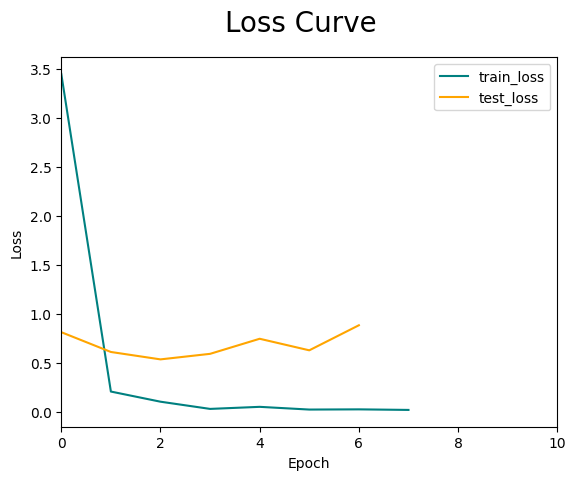

In [17]:
#==========================Loss Function===========================
fig = plt.figure()
plt.plot(train_loss_se, color = 'teal', label = 'train_loss')
plt.plot(test_loss_se, color = 'orange', label = 'test_loss')
fig.suptitle('Loss Curve', fontsize = 20)
plt.legend(loc = 'upper right')
plt.xlim(0,10)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

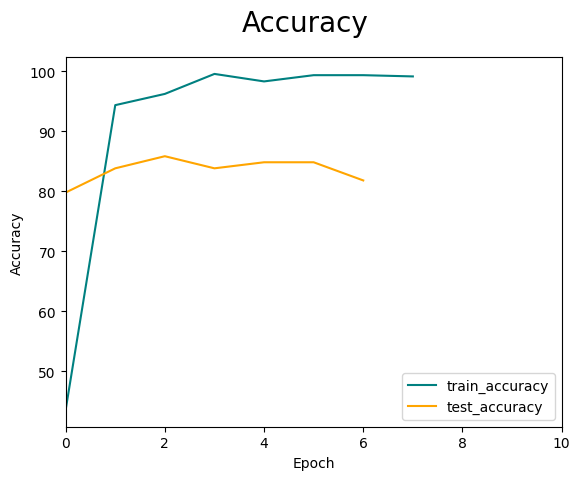

In [18]:
#==========================Accuracy===========================
fig = plt.figure()
plt.plot(train_accuracy_se, color = 'teal', label = 'train_accuracy')
plt.plot(test_accuracy_se, color = 'orange', label = 'test_accuracy')
fig.suptitle('Accuracy', fontsize = 20)
plt.legend(loc = 'lower right')
plt.xlim(0,10)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

## Prediction on New Images

In [24]:
chickenpox_val_df_cnn = predict_images_class(model_se, val_chicken_pox, IMAGE_WIDTH, IMAGE_HEIGHT)
display(chickenpox_val_df_cnn)

,Image No.,Predicted Image Class
0,1,ChickenPox
1,2,ChickenPox
2,3,ChickenPox
3,4,Measles
4,5,ChickenPox
5,6,ChickenPox
6,7,ChickenPox
7,8,ChickenPox


In [25]:
measles_val_df_cnn = predict_images_class(model_se, val_measles, IMAGE_WIDTH, IMAGE_HEIGHT)
display(measles_val_df_cnn)

,Image No.,Predicted Image Class
0,1,Measles
1,2,MonkeyPox
2,3,Measles
3,4,Measles
4,5,Measles
5,6,ChickenPox
6,7,ChickenPox
7,8,Measles


In [26]:
monkey_pox_df_cnn = predict_images_class(model_se, val_monkey_pox, IMAGE_WIDTH, IMAGE_HEIGHT)
display(monkey_pox_df_cnn)

,Image No.,Predicted Image Class
0,1,MonkeyPox
1,2,MonkeyPox
2,3,MonkeyPox
3,4,Measles
4,5,MonkeyPox
5,6,MonkeyPox
6,7,MonkeyPox
7,8,ChickenPox
